# Examples for the `ApproximateBayesianComputation` module

This notebook contains one simple toy example for each algorithm in the `ApproximateBayesianComputation` module. 

# Algorithms 
1. [ABC-RS](#alg_abcrs)
2. [ABC-MCMC](#alg_abcmcmc)
3. [ABC-PMC](#alg_abcpmc)


Install module.

In [1]:
Pkg.clone("https://github.com/SamuelWiqvist/ApproximateBayesianComputation.jl")

INFO: Cloning ApproximateBayesianComputation from https://github.com/SamuelWiqvist/ApproximateBayesianComputation.jl


LoadError: [91mApproximateBayesianComputation already exists[39m

Add processors to run the ABC-RS algorithm in parallel. 

In [2]:
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

Load packages. 

In [12]:
@everywhere using ApproximateBayesianComputation
@everywhere using Distributions
@everywhere using StatsBase
using KernelDensity
using PyPlot


## Example using the ABC-RS  algorithm <a name="alg_abcrs"></a>

We will now consider the Beta-Binomial model which is a model where the data model is a Binomial distrbution with paramaters $m$ and $p$, and the prior distribution is a Beta distribution with parameters $\alpha$ and $\beta$.  We can write the model as 

\begin{align*}
y &\sim \mathcal{B}(m, p), \\
p &\sim Beta(\alpha, \beta).
\end{align*}


Set up the data model for the Beta-Binomial model. 

In [4]:
# data model
@everywhere m = 4
@everywhere n = 5
p = 0.7

y = rand(Binomial(m,p),n) # generate data

5-element Array{Int64,1}:
 3
 1
 2
 3
 2

Set the prior distribution. 

In [6]:
# prior distribution
@everywhere α = 2 # hyper-parameters 
@everywhere β = 2

@everywhere prior = Beta(α, β)

Compute the analytical posterior distribution (we will compare this posterior to the ABC posterior later). 

In [7]:
# posterior, the posterior is analytically known for the beta-binomial model
posterior = Beta(α + sum(y), β + m*n - sum(y))


Distributions.Beta{Float64}(α=13.0, β=11.0)

Set up the functions needed for the ABC-RS algorithm. 

In [15]:
# function to sample from prior distribution
@everywhere sample_from_prior() = rand(prior)

# funciton to generate data from the model
@everywhere generate_data(p) = rand(Binomial(m,p),n)

# the summery statistics are just the generated data set
@everywhere calc_summary(y_star,y) = y_star

# compute absolute distance between the data sets up to permutations of the data
@everywhere ρ(s_star, s) = sum(abs.(sort(s_star)-sort(s)))

Create ABC rejection sampling problem. We are interested in computing exact Bayesin inference and we therefore set the threshold to zero. Hence, we will require an exact data match (up to permutations of the data) to accapt a proposal.

In [16]:
problem = ABCRS(10^6, 0, Data(y), 1, cores = length(workers()), print_interval = 10^5)

ApproximateBayesianComputation.ABCRS(1000000, 0, ApproximateBayesianComputation.Data([3, 1, 2, 3, 2]), 1, 4, 100000)

Run the ABC-RS algorithm. 

In [17]:
approx_posterior_samples = @time sample(problem,
                                        sample_from_prior,
                                        generate_data,
                                        calc_summary,
                                        ρ)

Starting ABC rejection sampling 
Running on 4 core(s)
Accuracy: ϵ: 0.000000
	From worker 3:	Percentage done (at each core): 0.00
	From worker 2:	Percentage done (at each core): 0.00
	From worker 5:	Percentage done (at each core): 0.00
	From worker 4:	Percentage done (at each core): 0.00
	From worker 3:	Percentage done (at each core): 40.00
	From worker 2:	Percentage done (at each core): 40.00
	From worker 5:	Percentage done (at each core): 40.00
	From worker 2:	Percentage done (at each core): 80.00
	From worker 5:	Percentage done (at each core): 80.00
	From worker 3:	Percentage done (at each core): 80.00
	From worker 4:	Percentage done (at each core): 40.00
	From worker 4:	Percentage done (at each core): 80.00
Ending ABC rejection sampling 
Accaptance rate: 2.75 %
  5.229771 seconds (1.68 M allocations: 101.824 MiB, 1.19% gc time)


1×27527 Array{Float64,2}:
 0.555364  0.309972  0.524529  0.404603  …  0.566265  0.648684  0.615571

Compute posterior qunatile intervals. 

In [18]:
posterior_quantile_interval = calcquantileint(approx_posterior_samples, print_on = true)

[0.341611 0.73216]

Plot posterior distribution. 

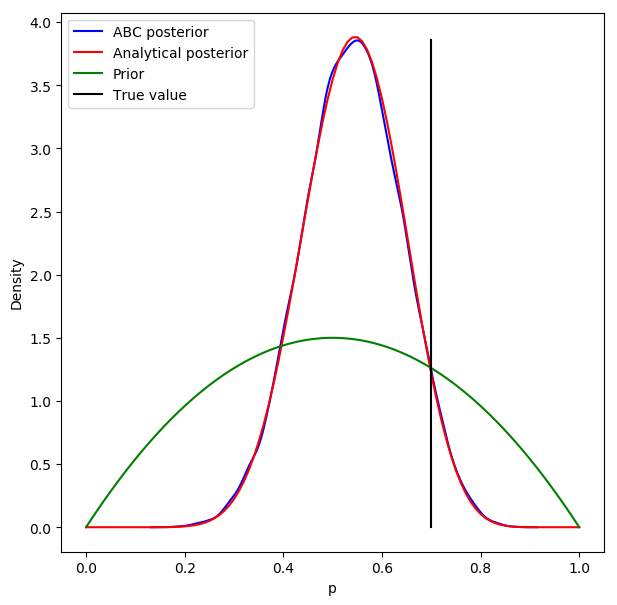

PyObject <matplotlib.legend.Legend object at 0x000000003A16B518>

In [19]:
# calc kernel density est. for approxiamte posterior
kde_approx_posterior = kde(approx_posterior_samples[:])

# plot results
PyPlot.figure(figsize=(7,7))
PyPlot.plot(kde_approx_posterior.x,kde_approx_posterior.density, "b")
PyPlot.plot(0:0.01:1,pdf.(posterior, 0:0.01:1), "r")
PyPlot.plot(0:0.01:1, pdf.(prior, 0:0.01:1), "g")
PyPlot.plot((p, p), (0, maximum(kde_approx_posterior.density)), "k")
PyPlot.xlabel("p")
PyPlot.ylabel("Density")
PyPlot.legend(["ABC posterior"; "Analytical posterior"; "Prior"; "True value"])

## Example using the ABC-MCMC  algorithm <a name="alg_abcmcmc"></a>

We will here estimate the parameters for the g-and-k distibution using the ABC-MCMC algorithm. We will use a similar set up as in the paper "Approximate maximum likelihood estimation using data-cloning ABC".

Set fixed paramete values.

In [13]:
N_data = 5*10^3 # nbr of observations
c = 0.8 # fixed parameter

0.8

Set up functions needed for the ABC-MCMC algorithm. 

In [14]:
# Sample from the Uniform prior distribution
sample_from_prior() = rand(Uniform(0, 10),4)


# Evaluate the prior dist on log-scale
function  evaluate_prior(Θ::Vector)

  # set start value for loglik
  log_prior = 0.
  for i = 1:length(Θ)
    log_prior += log_unifpdf( Θ[i], 0, 10 )
  end

  return log_prior # return log_lik

end

# Generate data from the model
function generate_data(Θ::Vector)

  A = Θ[1]
  B = Θ[2]
  g = Θ[3]
  k = Θ[4]

  z = rand(Normal(0,1), N_data)

  F_inv = similar(z)

  @inbounds for i = 1:length(F_inv)
    F_inv[i] = A + B*(1 + c*(1-exp(-g*z[i]))/(1+exp(-g*z[i])))*(1+z[i]^2)^k*z[i]
  end

  return F_inv

end

# Computes the summary statistics
calc_summary(y_sim::Vector, y_obs::Vector) = [percentile(y_sim, [20;40;60;80]);skewness(y_sim)]

# create distance function
w  =  [0.22; 0.19; 0.53; 2.97; 1.90]
ρ(s::Vector, s_star::Vector) = euclidean_dist(s::Vector, s_star::Vector, w)


ρ (generic function with 1 method)

Generate data. 

In [15]:
# generate data set
θ_true = [3; 1; 2; .5]
y = generate_data(θ_true)
data = Data(y)


ApproximateBayesianComputation.Data([3.83018, 2.97386, 4.28314, 2.24322, 2.45011, 2.9295, 4.73846, 1.82062, 2.39293, 4.8349  …  2.86391, 5.05534, 2.71797, 9.99321, 2.29985, 3.35688, 2.92488, 2.51957, 3.42778, 6.74189])

Set up ABC-MCMC problem. 

In [27]:
ϵ_seq = [30*ones(1000);20*ones(1000);10*ones(1000); 5*ones(1000); 2.5*ones(1000); 1*ones(1000); 0.5*ones(1000); 0.3*ones(100000)] # ; 0.05*ones(100000)
burn_in = length(ϵ_seq)-100000
N = length(ϵ_seq)
dim_unknown = 4
θ_start =  [5;5;3; 2] # fixed start values far away from the true parameter values
adaptive_update = AMUpdate(eye(dim_unknown), 2.4/sqrt(dim_unknown), 1., 0.7, 25) # use the AM algorithm to tune the proposal distribution
problem = ABCMCMC(N, burn_in, ϵ_seq, dim_unknown, θ_start, "none", data, adaptive_update, print_interval = 20000)


ApproximateBayesianComputation.ABCMCMC(107000, 7000, [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0  …  0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3], 4, [5, 5, 3, 2], "none", ApproximateBayesianComputation.Data([5.14784, 2.21413, 2.65504, 6.33883, 8.47528, 3.17155, 2.86215, 2.27477, 3.36159, 3.37365  …  2.65441, 2.57019, 4.72988, 2.97884, 12.6791, 3.1069, 5.44872, 8.98936, 5.37288, 2.21133]), ApproximateBayesianComputation.AMUpdate([1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], 1.2, 1.0, 0.7, 25), "original", 20000)

Run the ABC-MCMC algorithm.

In [28]:
chain = @time sample(problem,
                     sample_from_prior,
                     evaluate_prior,
                     generate_data,
                     calc_summary,
                     ρ)

Starting ABC-MCMC estimating 4 parameters
Adaptation algorithm: ApproximateBayesianComputation.AMUpdate
Iteration: 1
Covariance:
[1.44 0.0 0.0 0.0; 0.0 1.44 0.0 0.0; 0.0 0.0 1.44 0.0; 0.0 0.0 0.0 1.44]
Percentage done: 18.69 % 
Acceptance rate on iteration 1 to 20000 is 18.0709 % 
Covariance:
[0.0015611 0.00130706 -0.00646712 -0.000316823; 0.00130706 0.0153 0.0335851 -5.66574e-7; -0.00646712 0.0335851 0.184686 0.0148892; -0.000316823 -5.66574e-7 0.0148892 0.00780516]
Threshold: 0.3000 
Percentage done: 37.38 % 
Acceptance rate on iteration 20001 to 40000 is 18.8909 % 
Covariance:
[0.00115833 0.00201137 -0.00266569 -0.000604933; 0.00201137 0.0208204 0.0373418 -0.00375238; -0.00266569 0.0373418 0.158476 0.00621836; -0.000604933 -0.00375238 0.00621836 0.00981704]
Threshold: 0.3000 
Percentage done: 56.07 % 
Acceptance rate on iteration 40001 to 60000 is 19.1110 % 
Covariance:
[0.00141217 0.0021611 -0.00455908 -0.000839379; 0.0021611 0.0172131 0.0300167 -0.00144925; -0.00455908 0.0300167 0

4×107000 Array{Float64,2}:
 5.0  4.177     4.177     4.85531  6.51956  …  2.97173   2.97173   2.97173 
 5.0  6.28836   6.28836   4.52753  3.1118      0.999647  0.999647  0.999647
 3.0  1.50492   1.50492   2.78269  3.0122      2.57668   2.57668   2.57668 
 2.0  0.562198  0.562198  2.80275  1.91925     0.653372  0.653372  0.653372

Compute posterior quantile intervals. 

In [29]:
posterior_quantile_interval = calcquantileint(chain[:,burn_in+1:end], print_on = true)

[2.90886 3.03095; 0.761213 1.16615; 1.4946 2.7863; 0.425823 0.733382]

Plot chains. 

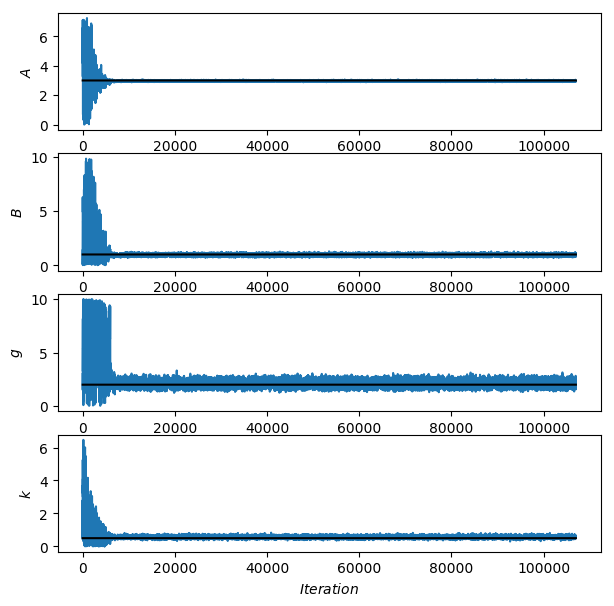

PyObject <matplotlib.text.Text object at 0x0000000037B8E320>

In [30]:
PyPlot.figure(figsize=(7,7))
PyPlot.subplot(411)
PyPlot.plot(chain[1,:])
PyPlot.plot(ones(size(chain,2),1)*θ_true[1], "k")
PyPlot.ylabel(L"$A$")
PyPlot.subplot(412)
PyPlot.plot(chain[2,:])
PyPlot.plot(ones(size(chain,2),1)*θ_true[2], "k")
PyPlot.ylabel(L"$B$")
PyPlot.subplot(413)
PyPlot.plot(chain[3,:])
PyPlot.plot(ones(size(chain,2),1)*θ_true[3], "k")
PyPlot.ylabel(L"$g$")
PyPlot.subplot(414)
PyPlot.plot(chain[4,:])
PyPlot.plot(ones(size(chain,2),1)*θ_true[4], "k")
PyPlot.xlabel(L"Iteration")
PyPlot.ylabel(L"$k$")

Plot chains after burn-in. 

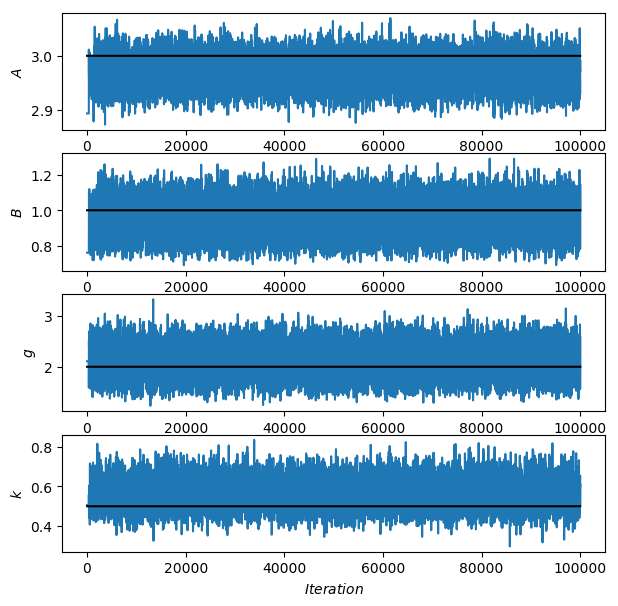

PyObject <matplotlib.text.Text object at 0x0000000048A38C18>

In [31]:
PyPlot.figure(figsize=(7,7))
PyPlot.subplot(411)
PyPlot.plot(chain[1,burn_in:end])
PyPlot.plot(ones(size(chain[:,burn_in:end],2),1)*θ_true[1], "k")
PyPlot.ylabel(L"$A$")
PyPlot.subplot(412)
PyPlot.plot(chain[2,burn_in:end])
PyPlot.plot(ones(size(chain[:,burn_in:end],2),1)*θ_true[2], "k")
PyPlot.ylabel(L"$B$")
PyPlot.subplot(413)
PyPlot.plot(chain[3,burn_in:end])
PyPlot.plot(ones(size(chain[:,burn_in:end],2),1)*θ_true[3], "k")
PyPlot.ylabel(L"$g$")
PyPlot.subplot(414)
PyPlot.plot(chain[4,burn_in:end])
PyPlot.plot(ones(size(chain[:,burn_in:end],2),1)*θ_true[4], "k")
PyPlot.xlabel(L"Iteration")
PyPlot.ylabel(L"$k$")

Plot marginal ABC posterior distributions. 

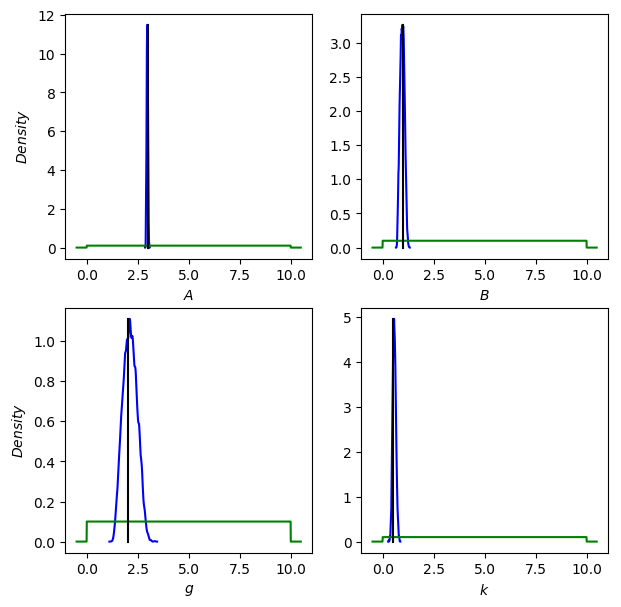

PyObject <matplotlib.text.Text object at 0x000000004865DC18>

In [32]:
# calc grid for prior dist
x_grid = -0.5:0.01:10.5

# calc prior dist
priordensity = pdf.(Uniform(0, 10), x_grid)


h1 = kde(chain[1,burn_in:end])
h2 = kde(chain[2,burn_in:end])
h3 = kde(chain[3,burn_in:end])
h4 = kde(chain[4,burn_in:end])

PyPlot.figure(figsize=(7,7))
subplot(221)
PyPlot.plot(h1.x,h1.density, "b")
PyPlot.plot(x_grid,priordensity, "g")
PyPlot.plot((θ_true[1], θ_true[1]), (0, maximum(h1.density)), "k")
PyPlot.ylabel(L"Density")
PyPlot.xlabel(L"$A$")
subplot(222)
PyPlot.plot(h2.x,h2.density, "b")
PyPlot.plot(x_grid,priordensity, "g")
PyPlot.plot((θ_true[2], θ_true[2]), (0, maximum(h2.density)), "k")
PyPlot.xlabel(L"$B$")
subplot(223)
PyPlot.plot(h3.x,h3.density, "b")
PyPlot.plot(x_grid,priordensity, "g")
PyPlot.plot((θ_true[3], θ_true[3]), (0, maximum(h3.density)), "k")
PyPlot.xlabel(L"$g$")
PyPlot.ylabel(L"Density")
subplot(224)
PyPlot.plot(h4.x,h4.density, "b")
PyPlot.plot(x_grid,priordensity, "g")
PyPlot.plot((θ_true[4], θ_true[4]), (0, maximum(h4.density)), "k")
PyPlot.xlabel(L"$k$")


Let us now run the same example using the general ABC-MCMC algorithm with the Gaussian kernel.

Set up distance function and Gaussian kernel. 

In [16]:

# set inv. covrance matrix
Ω_inv = inv(diagm(w.^2))

# set distance function
ρ(s::Vector, s_star::Vector) = gaussian_kernel_dist(s_star, s, Ω_inv)

# set kernel
abcmcmkernel(s_star::Vector,s::Vector, ϵ::Real, ρ::Function) = gaussian_kernel(s_star, s, ϵ, ρ)


abcmcmkernel (generic function with 1 method)

Create ABC problem. 

In [17]:
# create ABC-MCMC problem
ϵ_seq = [30*ones(1000);20*ones(1000);10*ones(1000); 5*ones(1000); 2.5*ones(1000); 1*ones(1000); 0.5*ones(1000); 0.3*ones(1000); 0.2*ones(1000); 0.1*ones(101000)] # ; 0.05*ones(100000)
burn_in = length(ϵ_seq)-100000
N = length(ϵ_seq)
dim_unknown = 4
θ_start =  [5;5;3; 2] # fixed start values far away from the true parameter values
adaptive_update = AMUpdate(eye(dim_unknown), 2.4/sqrt(dim_unknown), 1., 0.7, 25) # use the AM algorithm to tune the proposal distribution
problem = ABCMCMC(N, burn_in, ϵ_seq, dim_unknown, θ_start, "none", data, adaptive_update, print_interval = 20000; algorithm_type = "general")


ApproximateBayesianComputation.ABCMCMC(110000, 10000, [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 4, [5, 5, 3, 2], "none", ApproximateBayesianComputation.Data([3.83018, 2.97386, 4.28314, 2.24322, 2.45011, 2.9295, 4.73846, 1.82062, 2.39293, 4.8349  …  2.86391, 5.05534, 2.71797, 9.99321, 2.29985, 3.35688, 2.92488, 2.51957, 3.42778, 6.74189]), ApproximateBayesianComputation.AMUpdate(Real[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], 1.2, 1.0, 0.7, 25), "general", 20000)

Run the general ABC-MCMC algorithm. 

In [18]:
# run ABC-MCMC
chain = @time sample(problem,
                    sample_from_prior,
                    evaluate_prior,
                    generate_data,
                    calc_summary,
                    ρ;
                    kernel = abcmcmkernel)

Starting ABC-MCMC estimating 4 parameters
Adaptation algorithm: ApproximateBayesianComputation.AMUpdate
Iteration: 1
Covariance:
[1.44 0.0 0.0 0.0; 0.0 1.44 0.0 0.0; 0.0 0.0 1.44 0.0; 0.0 0.0 0.0 1.44]
Percentage done: 18.18 % 
Acceptance rate on iteration 1 to 20000 is 15.3108 % 
Covariance:
[0.00117749 0.00215109 -0.00103569 -0.000193834; 0.00215109 0.0131795 0.0212396 -0.000698421; -0.00103569 0.0212396 0.0930054 0.00749866; -0.000193834 -0.000698421 0.00749866 0.00605386]
Threshold: 0.1000 
Percentage done: 36.36 % 
Acceptance rate on iteration 20001 to 40000 is 15.6908 % 
Covariance:
[0.000940441 0.00090081 -0.00309184 -0.000360843; 0.00090081 0.0100187 0.0195055 -0.000470106; -0.00309184 0.0195055 0.0982763 0.00941267; -0.000360843 -0.000470106 0.00941267 0.00640513]
Threshold: 0.1000 
Percentage done: 54.55 % 
Acceptance rate on iteration 40001 to 60000 is 15.9558 % 
Covariance:
[0.00110549 0.00144922 -0.00264307 -0.000744882; 0.00144922 0.0101714 0.015488 -0.00240122; -0.002643

4×110000 Array{Float64,2}:
 5.0  7.55575  6.9475   8.49223  7.96883  …  3.02659  3.02895   3.02895 
 5.0  6.44413  4.73147  3.85795  1.44804     1.02098  1.08823   1.08823 
 3.0  2.41062  3.28426  6.52438  5.68262     2.09981  2.23267   2.23267 
 2.0  3.36329  3.08312  1.63027  2.4765      0.57686  0.572954  0.572954

Compute posterior quantile interval.  

In [19]:
posterior_quantile_interval = calcquantileint(chain[:,burn_in+1:end])

4×2 Array{Float64,2}:
 2.95055   3.05902 
 0.829849  1.19119 
 1.55434   2.58749 
 0.405304  0.682845

Plot chains.

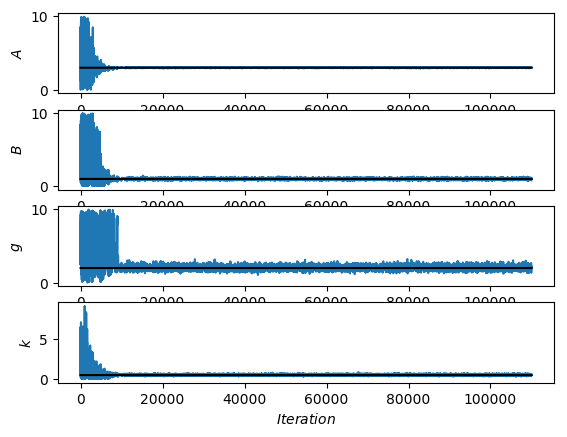

PyObject <matplotlib.text.Text object at 0x0000000032EA5710>

In [20]:

# plot chains
PyPlot.figure()
PyPlot.subplot(411)
PyPlot.plot(chain[1,:])
PyPlot.plot(ones(size(chain,2),1)*θ_true[1], "k")
PyPlot.ylabel(L"$A$")
PyPlot.subplot(412)
PyPlot.plot(chain[2,:])
PyPlot.plot(ones(size(chain,2),1)*θ_true[2], "k")
PyPlot.ylabel(L"$B$")
PyPlot.subplot(413)
PyPlot.plot(chain[3,:])
PyPlot.plot(ones(size(chain,2),1)*θ_true[3], "k")
PyPlot.ylabel(L"$g$")
PyPlot.subplot(414)
PyPlot.plot(chain[4,:])
PyPlot.plot(ones(size(chain,2),1)*θ_true[4], "k")
PyPlot.xlabel(L"Iteration")
PyPlot.ylabel(L"$k$")


Plot chains after burn-in. 

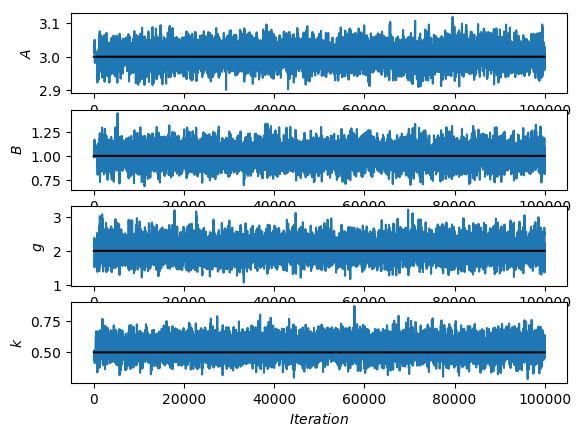

PyObject <matplotlib.text.Text object at 0x000000003DE59CC0>

In [21]:

# plot chains after burn in
PyPlot.figure()
PyPlot.subplot(411)
PyPlot.plot(chain[1,burn_in:end])
PyPlot.plot(ones(size(chain[:,burn_in:end],2),1)*θ_true[1], "k")
PyPlot.ylabel(L"$A$")
PyPlot.subplot(412)
PyPlot.plot(chain[2,burn_in:end])
PyPlot.plot(ones(size(chain[:,burn_in:end],2),1)*θ_true[2], "k")
PyPlot.ylabel(L"$B$")
PyPlot.subplot(413)
PyPlot.plot(chain[3,burn_in:end])
PyPlot.plot(ones(size(chain[:,burn_in:end],2),1)*θ_true[3], "k")
PyPlot.ylabel(L"$g$")
PyPlot.subplot(414)
PyPlot.plot(chain[4,burn_in:end])
PyPlot.plot(ones(size(chain[:,burn_in:end],2),1)*θ_true[4], "k")
PyPlot.xlabel(L"Iteration")
PyPlot.ylabel(L"$k$")


Plot marginal ABC posterior distributions. 

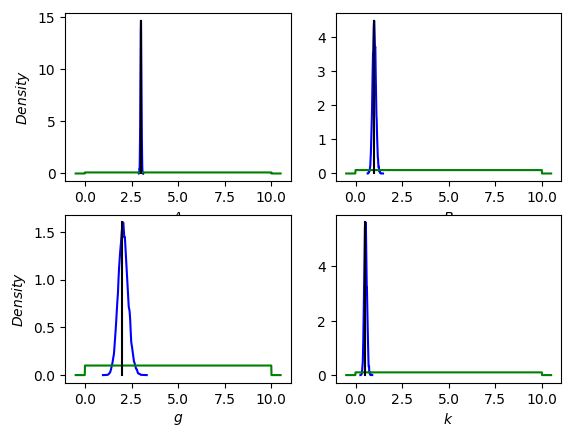

PyObject <matplotlib.text.Text object at 0x00000000402CC748>

In [22]:
# plot marginal posterior distributions

# calc grid for prior dist
x_grid = -0.5:0.01:10.5

# calc prior dist
priordensity = pdf.(Uniform(0, 10), x_grid)


h1 = kde(chain[1,burn_in:end])
h2 = kde(chain[2,burn_in:end])
h3 = kde(chain[3,burn_in:end])
h4 = kde(chain[4,burn_in:end])

PyPlot.figure()
subplot(221)
PyPlot.plot(h1.x,h1.density, "b")
PyPlot.plot(x_grid,priordensity, "g")
PyPlot.plot((θ_true[1], θ_true[1]), (0, maximum(h1.density)), "k")
PyPlot.ylabel(L"Density")
PyPlot.xlabel(L"$A$")
subplot(222)
PyPlot.plot(h2.x,h2.density, "b")
PyPlot.plot(x_grid,priordensity, "g")
PyPlot.plot((θ_true[2], θ_true[2]), (0, maximum(h2.density)), "k")
PyPlot.xlabel(L"$B$")
subplot(223)
PyPlot.plot(h3.x,h3.density, "b")
PyPlot.plot(x_grid,priordensity, "g")
PyPlot.plot((θ_true[3], θ_true[3]), (0, maximum(h3.density)), "k")
PyPlot.xlabel(L"$g$")
PyPlot.ylabel(L"Density")
subplot(224)
PyPlot.plot(h4.x,h4.density, "b")
PyPlot.plot(x_grid,priordensity, "g")
PyPlot.plot((θ_true[4], θ_true[4]), (0, maximum(h4.density)), "k")
PyPlot.xlabel(L"$k$")


## Example using the ABC-PMC  algorithm <a name="alg_abcpmc"></a>

We will  here use the ABC-PMC algorithm to estimate the parameters of the MA(2) process.

Set fixed paramters. 

In [33]:
@everywhere N_data = 100 # nbr of observations

Set up functions needed for the ABC-PMC algorithm. 

In [36]:
# prior distribtuion: The prior distribtuion: the parameters are defined on the triangle where -2 < θ_1 < 2, and  θ_1+θ_2 > 1, θ_1 - θ_2 < 1

# Sample from the Uniform prior distribution
@everywhere function sample_from_prior()

  while true
    θ_1 = rand(Uniform(-2,2))
    θ_2 = rand(Uniform(-1,1))
    if θ_2 + θ_1  >= -1 && θ_2 - θ_1 >= -1
      return [θ_1; θ_2]
    end
  end

end

# Evaluate prior distribtuion
@everywhere function evaluate_prior(Θ::Vector)
  θ_1 = Θ[1]
  θ_2 = Θ[2]
  if abs(θ_1) <= 2 && abs(θ_2) <= 1 &&  θ_2 + θ_1  >= -1 && θ_2 - θ_1 >= -1
    return 1.
  else
    return 0.
  end
end

# Generate data from the model
@everywhere function generate_data(Θ::Vector)

  θ_1 = Θ[1]
  θ_2 = Θ[2]

  if abs(θ_1) <= 2 && abs(θ_2) <= 1 &&   θ_2 + θ_1  >= -1 && θ_2 - θ_1 >= -1

    y = zeros(N_data)
    ϵ = randn(N_data)

    y[1] = ϵ[1]
    y[2] = ϵ[2] - θ_1*y[1]

    @inbounds for i = 3:N_data
      y[i] = ϵ[i] + θ_1*ϵ[i-1] + θ_2*ϵ[i-2]
    end

    return y
  else
    return NaN*ones(N_data)
  end

end

# Computes the summary statistics"
@everywhere calc_summary(y_sim::Vector, y_obs::Vector) = autocor(y_sim, 1:2)

# distance function 
@everywhere ρ(s::Vector, s_star::Vector) = euclidean_dist(s, s_star, ones(2))



Generate data. 

In [39]:
# generate data set
θ_true = [0.6; 0.2]
y = generate_data(θ_true)
data = Data(y)

ApproximateBayesianComputation.Data([2.42132, -1.85176, -1.41411, -2.54932, 0.127061, -0.630507, -1.30818, 1.20486, 1.32119, 1.31981  …  0.417095, 1.1302, -0.0254615, -0.673499, 1.56334, 0.716927, 1.68643, 1.19739, -1.33936, -1.93874])

Plot data 

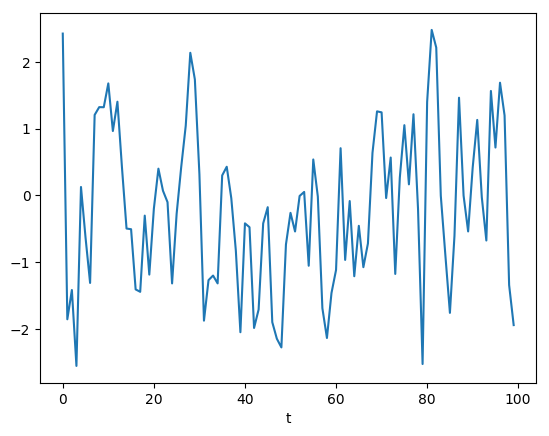

PyObject <matplotlib.text.Text object at 0x00000000487BADD8>

In [40]:
PyPlot.figure()
PyPlot.plot(y)
PyPlot.xlabel("t")

Set up ABC-PMC problem. 

In [42]:
ϵ_seq = [2; 1.5; 1; 0.5; 0.1; 0.01]
T = length(ϵ_seq)
N = 500
dim_unknown = 2
nbr_cores = length(workers())
problem = ABCPMC(T,N,ϵ_seq,data,dim_unknown,cores = nbr_cores)


ApproximateBayesianComputation.ABCPMC(6, 500, [2.0, 1.5, 1.0, 0.5, 0.1, 0.01], ApproximateBayesianComputation.Data([2.42132, -1.85176, -1.41411, -2.54932, 0.127061, -0.630507, -1.30818, 1.20486, 1.32119, 1.31981  …  0.417095, 1.1302, -0.0254615, -0.673499, 1.56334, 0.716927, 1.68643, 1.19739, -1.33936, -1.93874]), 2, 4, 1)

Run ABC-PMC algorithm. 

In [43]:
approx_posterior_samples = sample(problem,
                                  sample_from_prior,
                                  evaluate_prior,
                                  generate_data,
                                  calc_summary,
                                  ρ)

Starting PMC-ABC 
Running on 4 core(s)
Starting Threshold: ϵ = 2.0000
Iteraton: 2 
Percentage done: 16.67 % 
Threshold (current iteration): ϵ = 1.5000 
Accaptace rate (previous iteration): 100.0000 %
Iteraton: 3 
Percentage done: 33.33 % 
Threshold (current iteration): ϵ = 1.0000 
Accaptace rate (previous iteration): 62.0755 %
Iteraton: 4 
Percentage done: 50.00 % 
Threshold (current iteration): ϵ = 0.5000 
Accaptace rate (previous iteration): 59.6356 %
Iteraton: 5 
Percentage done: 66.67 % 
Threshold (current iteration): ϵ = 0.1000 
Accaptace rate (previous iteration): 42.6746 %
Iteraton: 6 
Percentage done: 83.33 % 
Threshold (current iteration): ϵ = 0.0100 
Accaptace rate (previous iteration): 10.4002 %
Accaptace rate (final iteration): 0.9392 %
Ending PMC-ABC 


2×500 Array{Float64,2}:
 0.847768  0.481588  0.474639  0.778389  …   0.624906   0.58913   0.518831
 0.412143  0.163635  0.019435  0.305353     -0.0819906  0.165092  0.442765

Plot porsterior distribution. 

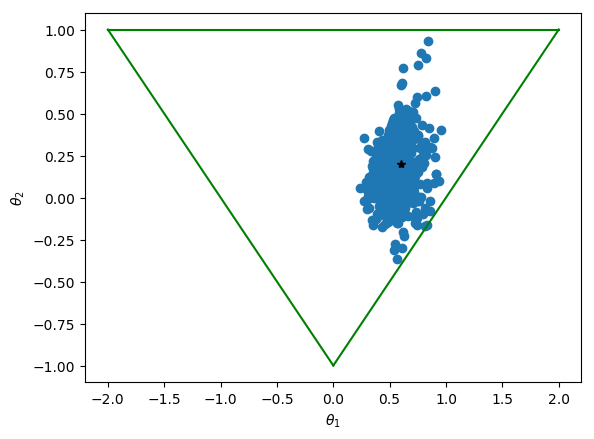

PyObject <matplotlib.text.Text object at 0x0000000048822DA0>

In [44]:
PyPlot.figure()
PyPlot.plot((0,-2),(-1,1), "g")
PyPlot.plot((-2,2),(1,1), "g")
PyPlot.plot((0,2),(-1,1), "g")
PyPlot.scatter(approx_posterior_samples[1,:],approx_posterior_samples[2,:])
PyPlot.plot(θ_true[1],θ_true[2], "k*")
PyPlot.xlabel(L"$\theta_1$")
PyPlot.ylabel(L"$\theta_2$")
